In [1]:
import sys
import os
sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))    # So can access functions in isca_tools which is in home/Isca directory
import isca_tools
from isca_tools.utils.moist_physics import rh_from_sphum
import metpy.calc
import metpy.constants
from metpy.units import units
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
# Load dataset
exp_name = 'play/rh_calc'
ds = isca_tools.load_dataset(exp_name)
namelist = isca_tools.load_namelist(exp_name)  # Need this for albedo_value
p_full = namelist['spectral_dynamics_nml']['reference_sea_level_press']     # pressure of entire atmosphere in Pa
ds_tropics = ds.sel(lon=[240.125], lat=[0], method="nearest")
ds_extropics = ds.sel(lon=[240.125], lat=[40.3], method="nearest")    # just consider one lat/lon coordinate
ds_list = [ds_tropics, ds_extropics]

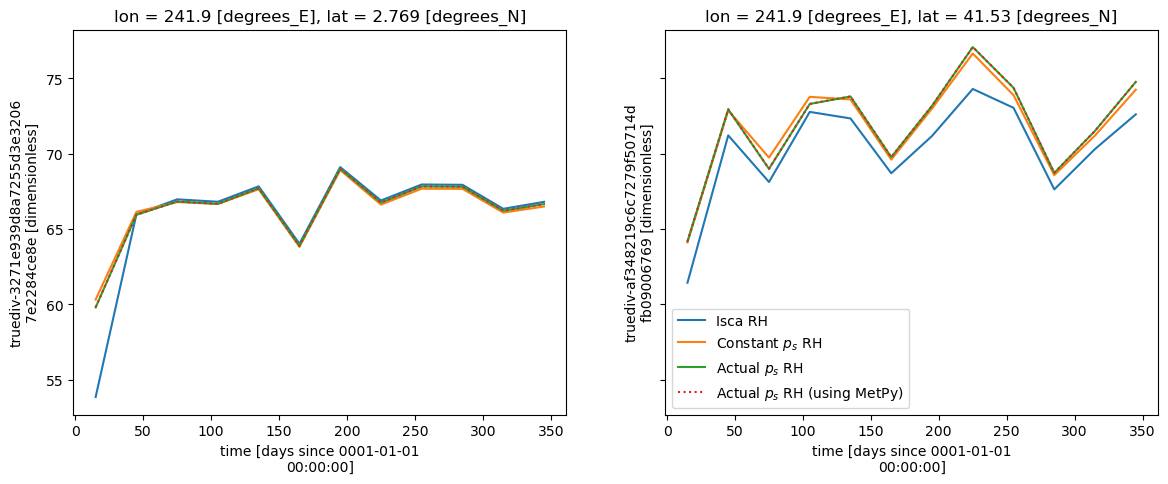

In [3]:
# Actual relative humidity
fig, axs = plt.subplots(1,len(ds_list), figsize=(14, 5), sharex=True, sharey=True)
for i in range(len(ds_list)):
    ds_list[i].rh_2m.plot(label='Isca RH', ax=axs[i])

    # Relative humidity calculated with single surface pressure
    rh_manual = rh_from_sphum(ds_list[i].sphum_2m, ds_list[i].temp_2m, p_full)
    rh_manual.plot(label='Constant $p_s$ RH', ax=axs[i])

    # Relative humidity calculated with actual surface pressure
    rh_manual2 = rh_from_sphum(ds_list[i].sphum_2m, ds_list[i].temp_2m, ds_list[i].ps)
    rh_manual2.plot(label='Actual $p_s$ RH', ax=axs[i])

    # Relative humidity computed using Metpy - this is exactly the same as above using actual surface pressure
    rh_metpy = metpy.calc.relative_humidity_from_specific_humidity(ds_list[i].ps * units.pascal, ds_list[i].temp_2m*units.kelvin,
                                                                   ds_list[i].sphum_2m*units.kilogram/units.kilogram) * 100

    rh_metpy.plot(label='Actual $p_s$ RH (using MetPy)', linestyle=':', ax=axs[i])

plt.legend();

From the above plot, we see that the 2m relative humidity computed by Isca is systematically larger than that obtained from the specific humidity and temperature values in the extratropics.

Isca computes the saturation vapour pressure using a lookup to values in the [Smithsonian tables](https://github.com/ExeClim/Isca/blob/9560521e1ba5ce27a13786ffdcb16578d0bd00da/src/shared/sat_vapor_pres/sat_vapor_pres.F90#L108-L111) so this may explain the difference.

Also, for this experiment (and most other examples on Isca), the option [`do_simple`](https://jduffield65.github.io/Isca/namelists/condensation/sat_vapor_pres/#do_simple) is set to `True` in the `sat_vapor_pres_nml` namelist. This could be another factor that may explain the difference.

The calculation does seem to work near the equator though.

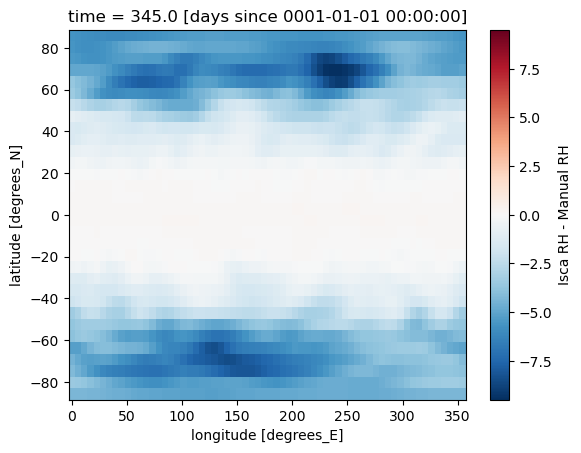

In [4]:
# Take a single time point and plot rh diff between Isca and calc as function of
# latitude and longitude
ds_one_year = ds.sel(time=[360], method="nearest")
rh_manual = rh_from_sphum(ds_one_year.sphum_2m, ds_one_year.temp_2m, ds_one_year.ps)
rh_diff = ds_one_year.rh_2m-rh_manual
rh_diff.name = 'Isca RH - Manual RH'
rh_diff.plot();

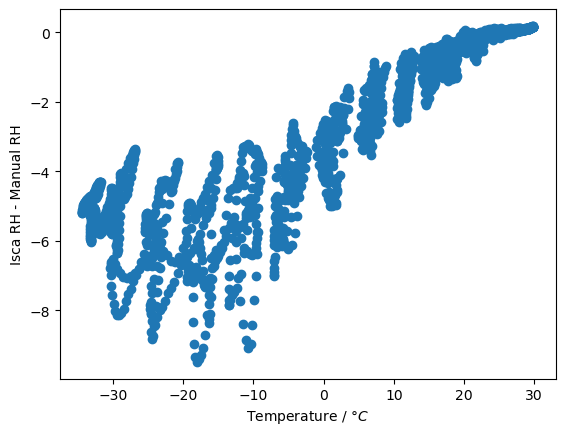

In [5]:
temp_2m_flat = ds_one_year.temp_2m.to_numpy().flatten() - 273.15
rh_diff_flat = rh_diff.to_numpy().flatten()
plt.scatter(temp_2m_flat, rh_diff_flat);
plt.xlabel('Temperature / $\degree C$');
plt.ylabel(rh_diff.name);

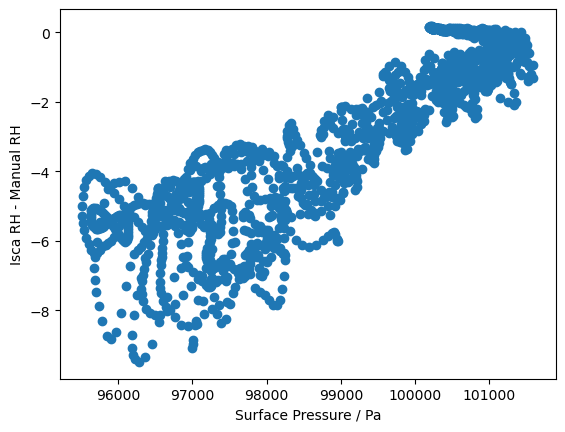

In [6]:
ps_flat = ds_one_year.ps.to_numpy().flatten()
plt.scatter(ps_flat, rh_diff_flat);
plt.xlabel('Surface Pressure / Pa');
plt.ylabel(rh_diff.name);

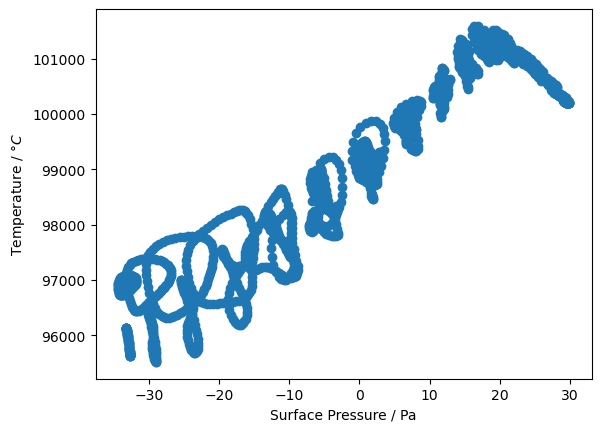

In [10]:
plt.scatter(temp_2m_flat, ps_flat);
plt.xlabel('Surface Pressure / Pa');
plt.ylabel('Temperature / $\degree C$');

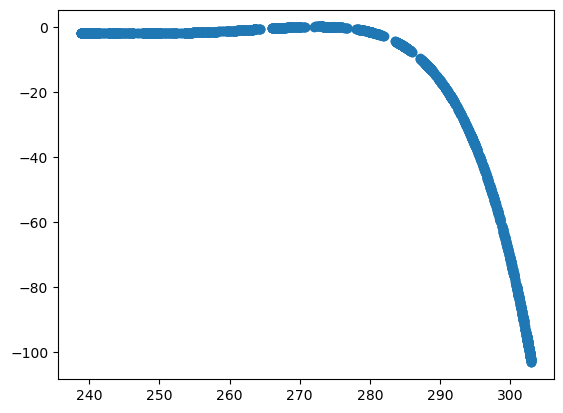

In [9]:
# Compare Bolton 1980 saturation vapor pressure computed using MATLAB exercise M9.2 equation in Holdon 2004
# But largest difference is for highest temperatures, where the Bolton 1980 equation works well, hence this is not the issue.
from isca_tools.utils.moist_physics import saturation_vapor_pressure
from isca_tools.utils.constants import L_v, R_v
temp_2m_flat_kelvin = temp_2m_flat+273.15
sat_p = saturation_vapor_pressure(temp_2m_flat_kelvin)
sat_p_holden = 611 * np.exp(L_v/R_v * (1/273.15 - 1/temp_2m_flat_kelvin))
plt.scatter(temp_2m_flat_kelvin, sat_p-sat_p_holden);